In [21]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import time
from tqdm import tqdm
import seaborn as sns #not needed to run program
import matplotlib.pyplot as plt #not needed to run program
import datetime
#import copy
import logging

In [22]:
logging.basicConfig(format = '%(asctime)s:%(levelname)s :%(message)s',
                        datefmt = '%Y-%m-%d %H:%M:%S',
                        filename = 'logs/run_main.log',
                        level=logging.INFO)

**1. Get current DAX constituents from wikipedia**

In [23]:
def replace_by_freq(dataframe, column_name, threshold, new_value):

    """
    Replace values in a column of a DataFrame based on their frequency count.

    Args:
        dataframe (pandas.DataFrame): The DataFrame to modify.
        column_name (str): The name of the column to replace values in.
        threshold (int): The frequency threshold. Values appearing less than this threshold will be replaced.
        new_value: The new value to replace the infrequent values with.

    Returns:
        pandas.DataFrame: The modified DataFrame with values replaced.

    Raises:
        KeyError: If the specified column is not found in the DataFrame.
        
    """

    try:
        unique = dataframe.groupby(column_name)[column_name].transform('size').lt(threshold)
        dataframe.loc[unique, column_name] = new_value
    except KeyError as ke:
        print(f'Column ', ke, 'is not found in a dataframe')
    
    return dataframe

In [24]:
def dax40_latest_constituents():
    
    """
    Retrieve the latest constituents of the DAX40 index from Wikipedia (https://en.wikipedia.org/wiki/DAX).

     Args:
       None

    Returns:
        pandas.DataFrame: DataFrame containing the latest DAX40 constituents.

    Raises:
        Exception: If the website URL is unreachable or does not exist.
        Exception: If the 'constituents' table cannot be found on the website.
        Exception: If there is an error while extracting columns from the table.
        KeyError: If there is an issue with the column index of the 'constituents' table.

    """

    url = 'https://en.wikipedia.org/wiki/DAX'
    response = requests.get(url)

    #Check if the connection is succesful
    try:
        response = requests.get(url)
        if response.ok:
            soup = BeautifulSoup(response.text, 'html.parser')
        else:
            raise Exception(f'Cannot reach website {url}')
    except:
        raise Exception(f'Website {url} does not exist')

    #check if table 'constituents' exists
    wiki_table_id = 'constituents'
    try:
        indiatable = soup.find('table',{'id': wiki_table_id,'class':'wikitable'})
        df = pd.read_html(str(indiatable))
    except:
        raise Exception(f'Table {wiki_table_id} cannot be found in {url}')

    #Extract columns from table
    extract_cols = ['Ticker', 'Company', 'Prime Standard Sector']
    try:
        dax_constituents = pd.DataFrame(df[0])[extract_cols]
        dax_constituents = dax_constituents.rename(columns = {'Prime Standard Sector': 'Sector', 'Company': 'Name'})
    except KeyError as e:
        raise Exception((e.args[0]).replace('index', 'column index of table constituents'))

    dax_constituents = replace_by_freq(dax_constituents, 'Sector', 2, 'Other')

    logging.info(f'DAX40 constituents loaded successfully')

    return dax_constituents

In [25]:
# #Test
dax_comp = dax40_latest_constituents()
# print(dax_comp.head(20))

<AxesSubplot:xlabel='Sector'>

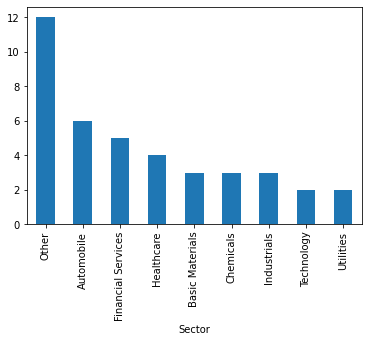

In [26]:
dax_comp.groupby(['Sector'])['Sector'].count().sort_values(ascending=False).plot.bar()

In [27]:
dax_comp.head(5)

,Ticker,Name,Sector
0,ADS.DE,Adidas,Other
1,AIR.DE,Airbus,Other
2,ALV.DE,Allianz,Financial Services
3,BAS.DE,BASF,Basic Materials
4,BAYN.DE,Bayer,Healthcare


In [28]:
def column_to_list_from_df(df, column_name):

    """
    Retrieve the values from a specific column in a DataFrame and convert them to a list.

    Args:
        df (pandas.DataFrame): The DataFrame containing the desired column.
        column_name (str): The name of the column to extract values from.

    Returns:
        list: A list containing the values from the specified column.

    Raises:
        KeyError: If the specified column does not exist in the DataFrame.
        Exception: If an error occurs while retrieving the column values.
        
    """

    try:
        output = df[column_name].values.tolist()
        return output
    except KeyError:
        raise KeyError(f"Column '{column_name}' does not exist in the DataFrame.")
    except:
        raise Exception("An error occurred while retrieving the column values.")


In [29]:
#A list of tickers from contituents
dax_tickers = column_to_list_from_df(dax_comp, 'Ticker')

In [30]:
print(dax_tickers)

['ADS.DE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE', 'BMW.DE', 'BNR.DE', 'CBK.DE', 'CON.DE', '1COV.DE', 'DTG.DE', 'DBK.DE', 'DB1.DE', 'DPW.DE', 'DTE.DE', 'EOAN.DE', 'FRE.DE', 'HNR1.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'MBG.DE', 'MRK.DE', 'MTX.DE', 'MUV2.DE', 'P911.DE', 'PAH3.DE', 'QIA.DE', 'RHM.DE', 'RWE.DE', 'SAP.DE', 'SRT3.DE', 'SIE.DE', 'ENR.DE', 'SHL.DE', 'SY1.DE', 'VOW3.DE', 'VNA.DE', 'ZAL.DE']


**2.Download monthly data from yahoo API**

In [31]:
def get_stock_price(ticker, start_date = "2001-04-01", end_date = "2023-01-01", price_interval = '1mo'):

    """
    Retrieve historical stock prices for a given ticker symbol within a specified time period and price interval.

    Args:
        ticker (str): Ticker symbol of the stock.
        start_date (str, optional): Start date of the desired time period in 'YYYY-MM-DD' format. Default is '2001-04-01'.
        end_date (str, optional): End date of the desired time period in 'YYYY-MM-DD' format. Default is '2023-01-01'.
        price_interval (str, optional): Interval at which to retrieve stock prices. Acceptable values are: '1m', '2m', '5m',
            '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'. Default is '1mo'.

    Returns:
        pandas.Series: Series containing the closing stock prices.

    Raises:
        ValueError: If the specified price interval is not in the list of acceptable interval types.
        ValueError: If the stock either does not exist or does not have data for the given time period.
    
    """


    interval_types = ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

    if price_interval not in interval_types:
        raise ValueError(f'Unknown interval type: {price_interval}. Acceptable arguments are {interval_types}')
    

    stock_data = yf.Ticker(ticker)
    stock_series = stock_data.history(start = start_date, end = end_date, interval = price_interval).Close

    if stock_series.empty:
        raise ValueError(f'{ticker} either does not exist or does not have data for a given time period')

    return stock_series


In [32]:
def convert_datetime_index_to_date(df):

    """
    Convert the datetime index of a DataFrame to date only.

    Args:
        df (pandas.DataFrame): The DataFrame to convert.

    Returns:
        pandas.DataFrame: The DataFrame with the datetime index converted to date only.

    Raises:
        Exception: If an AttributeError occurs during the conversion process.
    
    """    

    try:
        df.index = pd.to_datetime(df.index.date)
    except AttributeError as e:
        raise Exception(f'Could not convert index of a dataframe to date. Error message: {e}')
    return df

In [33]:
def get_data(tickers):

    """
    Retrieve historical stock price data for a list of tickers.

    Args:
        tickers (list): List of ticker symbols for the stocks.

    Returns:
        pandas.DataFrame: DataFrame containing historical stock price data for the given tickers.

    """

    output = {}
    tickers_downloaded = []

    with tqdm(total = len(tickers)) as pbar:
        for one_ticker in tickers:
            pbar.set_postfix_str(one_ticker)
            try:
                stock_price = get_stock_price(ticker = one_ticker)
                output[one_ticker] = stock_price
                tickers_downloaded.append(one_ticker)
            except ValueError as e:
                logging.warning(f'Non-existent ticker {one_ticker} or no data for given time interval')
                pass
            pbar.update()
            time.sleep(0.5)
    
    output = pd.DataFrame(output)
    output = convert_datetime_index_to_date(output)

    logging.info(f'Successfully downloaded stocks {tickers_downloaded}')
    
    return output

In [34]:
# dax_tickers_sample = ['ADS.DEE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DEE', '1COV.DE']

In [35]:
dax_data = get_data(tickers = dax_tickers)

100%|██████████| 40/40 [00:45<00:00,  1.15s/it, ZAL.DE] 


In [36]:
# dax_data.head(5)

In [37]:
# plt.figure(figsize=(19,12))
# sns.heatmap(dax_data.isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# plt.savefig("dax40_missing_values.png", dpi=100)

In [38]:
def drop_columns_with_na(df):

    """
    Drop columns from a DataFrame that contain any missing values (NA).

    Args:
        df (pandas.DataFrame): The DataFrame to process.

    Returns:
        pandas.DataFrame: The DataFrame with columns containing missing values dropped.

    Raises:
        Exception: If an error occurs while dropping columns with NA.

    """

    try:
        columns_contain_na = df.columns[df.isnull().any()].tolist()
        df_dropped = df.drop(columns=columns_contain_na)
    except:
        raise Exception('Could not drop columns with NA')

    logging.info(f'{(columns_contain_na)} contain NA values. They are dropped from the dataframe')

    return df_dropped

In [39]:
dax_data = drop_columns_with_na(dax_data)

In [40]:
# plt.figure(figsize=(19,12))
# sns.heatmap(dax_data_clean.isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# #plt.savefig("dax40_missing_values.png", dpi=100)

In [41]:
#at least two time series should be to do mvp